In [32]:

import scipy
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc



In [33]:
def read_gt(gt_file):
    gt = []
    with open(gt_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            items = line.split()
            class_id = int(items[0])
            xc = float(items[1])
            yc = float(items[2])
            w = float(items[3])
            h = float(items[4])
            gt.append([xc, yc, w, h, class_id])
            
    
    return np.array(gt)

def read_yolo_pred(pred_file):
    with open(pred_file, 'r') as f:
        lines = f.readlines()
    preds = []
    for line in lines:
        line = line.strip()
        if len(line) == 0:
            continue
        items = line.split()
        xc = float(items[0])
        yc = float(items[1])
        w = float(items[2])
        h = float(items[3])
        class_id = int(float(items[4]))
        conf = float(items[5])
        pred = [xc, yc, w, h, class_id, conf]
        preds.append(pred)
        
    
    return np.array(preds)

In [34]:
def get_cancer_label(filename):
    anots = read_gt(filename)
    if len(anots) == 0:
        return 0
    return int(anots[:, -1].max())


def get_score(filename):
    preds = read_yolo_pred(filename)
    if len(preds) == 0:
        return 0.0
    preds = preds[preds[:, -2] ==1]
    if len(preds) == 0:
        return 0.0
    
    return preds[:, -1].max()
    
df['cancer'] = df['gt'].apply(get_cancer_label)
df['score'] = df['pred'].apply(get_score)


    


In [46]:

def calculate_AUC(dataset_folder):
    print(dataset_folder)
    all_gt = list((dataset_folder/'labels').glob('*.txt'))
    all_preds = [pathlib.Path(str(p).replace('labels', 'fasterrcnn_predictions')) for p in all_gt]
    print("num of pred files", len(list(all_preds)))
    df = pd.DataFrame({'gt': all_gt, 'pred': all_preds})
    df['cancer'] = df['gt'].apply(get_cancer_label)
    df['score'] = df['pred'].apply(get_score)
    
    #plot ROC curve
    fpr, tpr, thresholds = roc_curve(df['cancer'], df['score'])
    sensibility = tpr
    specificity = 1-fpr
    
    plt.plot(specificity, sensibility)
    plt.xlabel('Specificity')
    plt.ylabel('Sensibility')
    
    #find specificity at 90% sensibility
    sensibility_90 = 0.9
    idx = np.argmin(np.abs(sensibility - sensibility_90))
    spec_90 = specificity[idx]
    print("Specificity at 90% sensibility", spec_90)

    #compute AUC for cancer
    return roc_auc_score(df['cancer'], df['score'])


/home/alalbiol/Data/mamo/inbreast_yolo/validation
num of pred files 410
Specificity at 90% sensibility 0.5732087227414331


0.8866778676187477

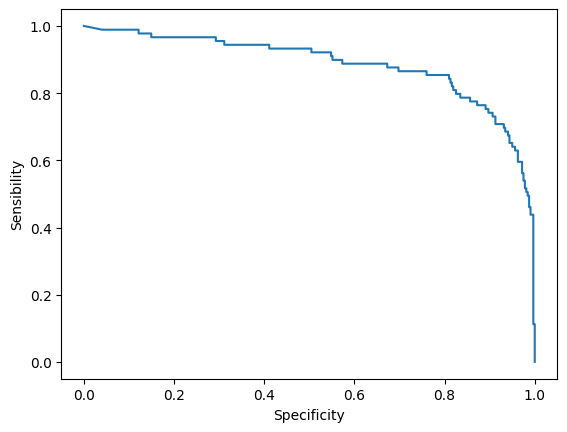

In [47]:
dataset_folder = pathlib.Path('/home/alalbiol/Data/mamo/inbreast_yolo/validation/')
calculate_AUC(dataset_folder)


/home/alalbiol/Data/mamo/ddsm_yolo/validation
num of pred files 2084
Specificity at 90% sensibility 0.4521739130434783


0.8261999919260424

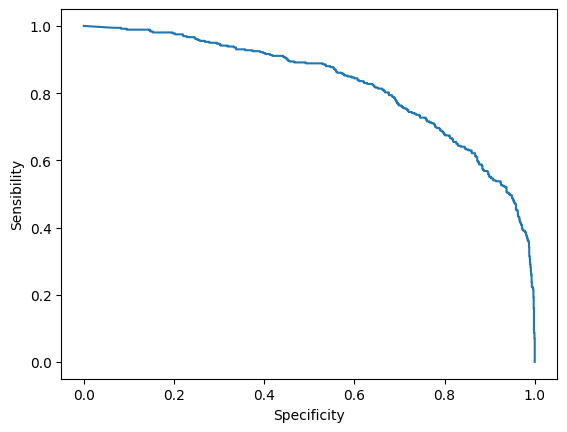

In [48]:
dataset_folder = pathlib.Path('/home/alalbiol/Data/mamo/ddsm_yolo/validation/')
calculate_AUC(dataset_folder)